In [1]:
from esda.moran import Moran
import geopandas as gpd
import json
import numpy as np
import pandas as pd
from libpysal.weights import DistanceBand, KNN
from matplotlib import colors
import matplotlib.pyplot as plt
from splot.esda import plot_moran
import spreg

from statshelper import q_q_plot
sns.set(style="whitegrid")
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

In [4]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
gdf = gdf.sample(frac=.025)
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
228086,0.820362,-1.481514,-1.559710,-0.987479,-1.184501,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.596010,-1.440712,-0.482322,-1.529858,18134050210000,91,21,POINT (432893.231 4626008.535)
259903,-0.326034,0.550809,-0.195502,-1.284598,-0.142768,-0.599533,0.635637,0.550000,-0.041762,1.066654,2.087330,-0.268846,0.519262,-1.632996,31031070140000,10,32,POINT (439302.705 4600707.879)
268456,1.266183,0.550809,0.889726,0.802192,0.929730,-0.599533,0.635637,-2.100215,-0.041762,-0.848209,-0.583418,1.734472,-1.233509,1.474353,13132240280000,110,71,POINT (442795.997 4645990.758)
225469,-1.790873,-0.292681,-0.107861,-0.219865,-1.216132,-0.599533,-0.891279,0.550000,-0.041762,1.066654,-0.913005,-0.268846,0.394064,-0.867963,20083050370000,91,72,POINT (445301.368 4627762.895)
215079,1.903069,1.739642,1.150458,1.231055,2.140516,-0.599533,1.528825,0.550000,-0.041762,-0.848209,-0.894542,2.179995,0.143668,0.898502,14302250150000,81,73,POINT (444528.536 4642558.230)


In [5]:
gdf.describe()

,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code
count,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8107.000000,8.107000e+03,8107.000000,8107.000000
mean,0.016771,0.013756,0.005738,-0.002501,0.020599,0.008630,-0.000277,-0.003776,-0.021695,-0.010012,-0.000058,0.011383,-0.009111,0.005956,1.646255e+13,109.691995,45.158012
std,0.995886,1.021411,1.006431,1.005113,1.006584,1.009625,1.014715,1.003644,0.681558,0.993626,0.996725,1.022418,1.000131,0.996055,8.013146e+12,99.319883,23.702856
min,-2.077472,-3.513837,-3.012991,-6.329397,-5.739673,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,-5.640353,-3.444030,-1.734301,-3.171978,1.011000e+12,10.000000,10.000000
25%,-0.580788,-0.292681,-0.760783,-0.634033,-0.623693,-0.599533,-0.891279,-0.775107,-0.041762,-0.848209,-0.596010,-0.795788,-0.857915,-0.479265,1.036312e+13,39.000000,24.000000
50%,-0.166812,-0.292681,-0.177690,-0.002917,-0.080690,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.106279,-0.268846,0.018470,0.104553,1.605320e+13,80.000000,37.000000
75%,0.820362,0.550809,0.659342,0.602896,0.543264,1.422378,0.635637,0.550000,-0.041762,1.066654,0.604457,0.562606,0.894856,0.631425,2.231712e+13,150.000000,71.000000
max,2.667333,5.804289,4.768203,5.254593,7.154818,2.605121,4.181025,0.550000,25.987333,4.101639,6.871268,5.355179,1.646044,3.878824,3.331109e+13,560.000000,77.000000


In [6]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

In [7]:
w.transform = 'R'

In [8]:
sem = spreg.ML_Error(y, X, w=w, name_x=i_vars, name_y="Sale Price")

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


In [9]:
print(sem.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :      0.0060                Number of Variables   :          14
S.D. dependent var  :      0.9961                Degrees of Freedom    :        8093
Pseudo R-squared    :      0.4641
Sigma-square ML     :       0.245                Log likelihood        :   -5932.230
S.E of regression   :       0.495                Akaike info criterion :   11892.461
                                                 Schwarz criterion     :   11990.468

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

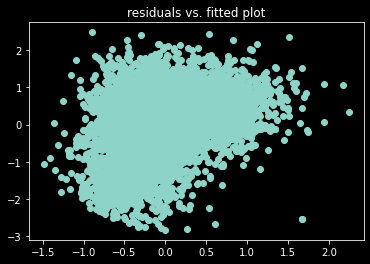

In [10]:
plt.scatter(sem.predy, sem.u)
plt.title("residuals vs. fitted plot")
plt.show()

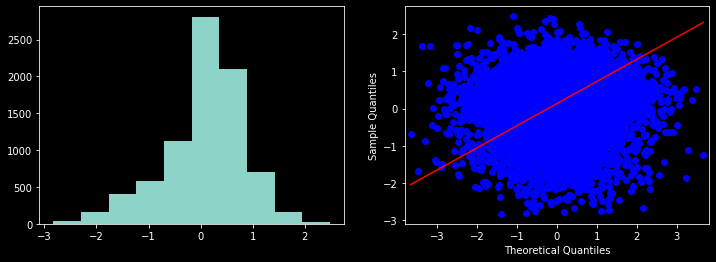

In [11]:
q_q_plot(sem.u)

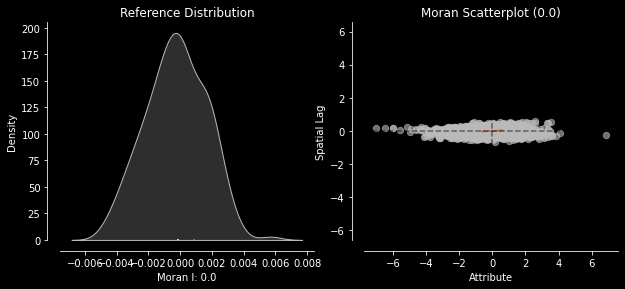

In [12]:
sem_moran = Moran(sem.e_filtered, w, permutations=199)
plot_moran(sem_moran, zstandard=True, figsize=(10,4))
plt.show()

-3.4884175698690107 3.415156993928163


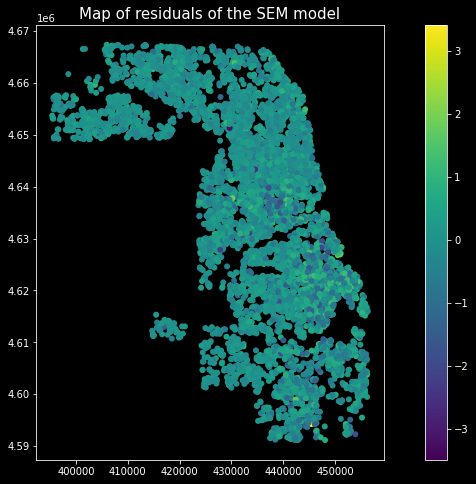

In [13]:
data = sem.e_filtered.reshape(-1)
_min, _max = min(data), max(data)
print(_min, _max)
_width = (_max-_min)
#norm = colors.BoundaryNorm(np.arange(_min, int(_max), _width/7),ncolors=256)
#ax = gdf.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), norm=norm, linewidth=0.0)
ax = gdf.plot(column=sem.e_filtered.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SEM model",fontsize=15)
plt.show()